Main idea:

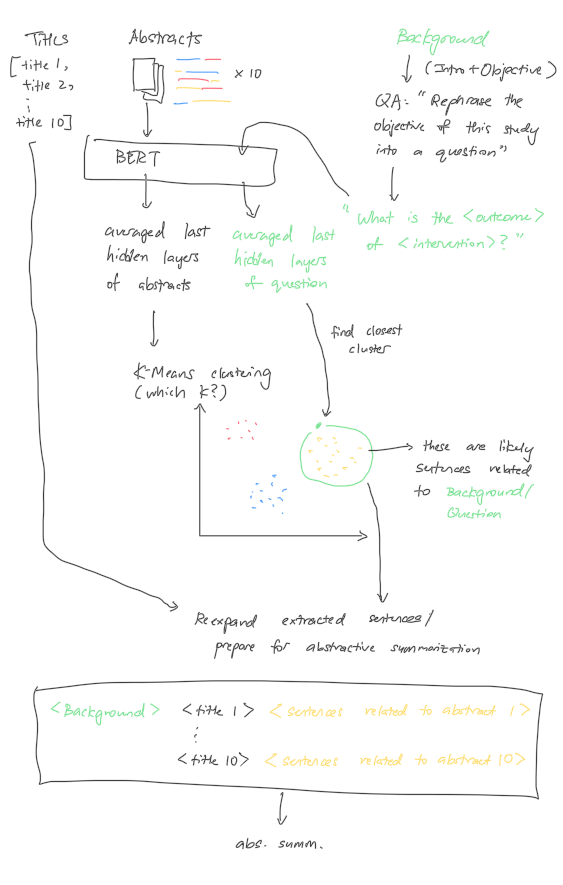

***Extractive step: BERT, K means***

In [211]:
import typing

from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.cluster import KMeans
from datasets import load_dataset
import pandas as pd
from pprint import pprint


# Load the dataset and cut down to the first 5 for demonstration
full_dataset = load_dataset("allenai/mslr2022", "ms2", split='validation')
dataset = full_dataset.select(range(3))  # Use select to create a subset

# Initialize BERT
bert_model_to_use = "dmis-lab/biobert-v1.1"
tokenizer = BertTokenizer.from_pretrained(bert_model_to_use)
model = BertModel.from_pretrained(bert_model_to_use)

In [217]:
def clean_text(text):
    """Clean text:
    - replace line breaks (\n) with spaces
    - replace " r and om" with "random" -- this word lemma occurs a lot in medical text!
    - same with "st and ard" -> "standard"
    - replace " ed " with "ed " -- past tense verbs are often separated from the word stem in this dataset
    - remove text "( ABSTRACT TRUNCATED" and everything after it, if it exists
    """
    text = text.replace('\n', ' ')
    text = text.replace(' r and om', ' random')
    text = text.replace(' st and ard', ' standard')
    text = text.replace(' ed ', 'ed ')
    if '( ABSTRACT TRUNCATED' in text:
        text = text[:text.index('( ABSTRACT TRUNCATED')]
    return text

def split_sentences(text):
    """From one abstract, split into sentences and return a list of sentences."""
    return text.split(' . ')


def bert_sentence_embeddings(sentences: typing.List[str]):
    inputs = tokenizer(sentences, return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        embeddings = model(**inputs)
    # embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    # return np.array(embeddings)
    return embeddings.last_hidden_state.mean(dim=1).numpy()


def cluster_kmeans(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    return kmeans, cluster_labels
    top_sentence_indices = np.argmin(
        np.linalg.norm(embeddings[:, np.newaxis] - kmeans.cluster_centers_, axis=2),
        axis=0,
    )
    top_sentences = [sentences[index] for index in sorted(top_sentence_indices)]
    return ' '.join(top_sentences)

def process_row(row):
    review_id = row['review_id']
    abstract_list = row['abstract']

    combined_summary = ''

    for abstract in abstract_list:
        # Check if the abstract is a string; if not, join it into a single string
        abstract_text = ' '.join(abstract) if isinstance(abstract, list) else abstract

        # Split abstract into sentences
        sentences = abstract_text.split('. ')
        # Generate embeddings for each sentence
        embeddings = bert_sentence_embeddings(sentences)
        # Select the top sentences from these embeddings
        summary = select_top_sentences(sentences, embeddings)

#         # Print the top sentences for debugging
        print("Top sentences for this abstract:", summary)


        # Combine the summaries from each abstract
        combined_summary += summary + ' '

    return {"review_id": review_id, "summary": combined_summary.strip()}


# test
example_idx = 0
abstract_idx = 1
test_row = dataset[example_idx]
abstract = test_row['abstract'][abstract_idx]
clean_abstract = clean_text(abstract)
print("original:", abstract)
print("clean   :", clean_abstract)

test_split_sentences = split_sentences(clean_abstract)
print("split   :", test_split_sentences)


# split for all abstracts, concatenate into a single list while keeping track of which abstract idx it came from
all_split_sentences = []
abstract_idx_to_sentence_idx = []
for abstract_idx, abstract in enumerate(test_row['abstract']):
    clean_abstract = clean_text(abstract)
    one_abstract_split_sentences = split_sentences(clean_abstract)
    all_split_sentences.extend(one_abstract_split_sentences)
    abstract_idx_to_sentence_idx.extend([abstract_idx] * len(one_abstract_split_sentences))

# print with abstract idx per new line; only for first 3 abstracts
for abstract_idx, sentence in zip(abstract_idx_to_sentence_idx, all_split_sentences):
    if abstract_idx > 2:
        break
    print(f"{abstract_idx:2d}:", sentence)

test_embeddings = bert_sentence_embeddings(all_split_sentences)
print("avg'ed embeddings shape:", test_embeddings.shape)

# Also get the embedding for the background
test_background_embedding = bert_sentence_embeddings([clean_text(test_row["background"])])[0]
print(f"{test_background_embedding.shape=}")

# Apply the function to each element of the dataset
# summaries_dataset = dataset.map(process_row)

# Convert to pandas DataFrame
# df = pd.DataFrame(summaries_dataset)
# df = df[['review_id', 'summary']]
# Save to CSV
# csv_file_path = 'test.csv'  # Update with your desired file path
# df.to_csv(csv_file_path, index=True)

# print(f"Saved summaries to {csv_file_path}")

original: Preterm infants have an impaired gut barrier function . We aim ed to determine the effects of enteral supplementation of a prebiotic mixture consisting of neutral oligosaccharides ( short-chain galacto-oligosaccharides (SCGOS)/long-chain fructo-oligosaccharides ( LCFOS ) ) and acidic oligosaccharides ( AOS ) on intestinal permeability of preterm infants as measured by the sugar absorption test in the first week of life . Furthermore , we determined host- and treatment-related factors associated with intestinal permeability . In a r and omised controlled trial , preterm infants with a gestational age < 32 weeks and /or birth weight ( BW ) < 1500 g received enteral supplementation of SCGOS/LCFOS/AOS or placebo ( maltodextrin ) between days 3 and 30 of life . Intestinal permeability , reflected by the urinary lactulose/mannitol ( L/M ) ratio after oral ingestion of lactulose and mannitol , was assessed at three time points : before the start of the study ( t = 0 ) , at day 4 ( t

In [219]:
pprint(test_row["background"])

('Necrotizing enterocolitis ( NEC ) is one of the most serious '
 'gastrointestinal emergencies in very low birth weight ( VLBW ) preterm '
 'neonates , affecting 7 - 14 % of these neonates .\n'
 'Due to the seriousness of the disease , prevention of NEC is the most '
 'important goal .')


In [157]:
objective_words = ["objective", "goal", "aim", "purpose"]
[b for b in full_dataset["background"] if (any(o in b.lower() for o in objective_words))]

['Necrotizing enterocolitis ( NEC ) is one of the most serious gastrointestinal emergencies in very low birth weight ( VLBW ) preterm neonates , affecting 7 - 14 % of these neonates .\nDue to the seriousness of the disease , prevention of NEC is the most important goal .',
 'BACKGROUND Several clinical trials have investigated the impact of glucomannan on plasma lipids , body weight , fasting blood glucose ( FBG ) , and blood pressure ( BP ) , but have yielded conflicting results and had only modest sample sizes .\nOBJECTIVE The objective was to perform a meta- analysis of r and omized controlled trials of glucomannan to better characterize its impact on plasma lipids , FBG , body weight , and BP .',
 'PURPOSE The goal of this meta- analysis was to determine the clinical utility of  acute mountain sickness ( AMS ) history to predict future incidents of AMS .',
 'The purpose of the current study was to clarify the role of the quadriceps tendon ( QT ) autograft for primary ACL reconstruc

In [207]:
full_dataset["abstract"][0]

["ABSTRACT A healthy intestinal microbiota is considered to be important for priming of the infants ' mucosal and systemic immunity . Breast-fed infants typically have an intestinal microbiota dominated by different Bifidobacterium species . It has been described that allergic infants have different levels of specific Bifidobacterium species than healthy infants . For the accurate quantification of Bifidobacterium adolescentis , Bifidobacterium angulatum , Bifidobacterium bifidum , Bifidobacterium breve , Bifidobacterium catenulatum , Bifidobacterium dentium , Bifidobacterium infantis , and Bifidobacterium longum in fecal sample s , duplex 5′ nuclease assays were developed . The assays , targeting rRNA gene intergenic spacer regions , were vali date d and compared with conventional PCR and fluorescent in situ hybridization methods . The 5′ nuclease assays were subsequently used to determine the relative amounts of different Bifidobacterium species in fecal sample s from infants receivi

In [214]:
# [[b for b in a if "conclusion" not in b.lower()] for a in full_dataset["abstract"][:1]]
[[b for b in a if "abstract truncated" in b.lower()] for a in full_dataset["abstract"][:2]]
# [b for a in full_dataset["abstract"] for b in a if "abstract truncated" in b.lower()]

[[],
 ['Dietary fibres are frequently used for the treatment of paediatric obesity . The aim of this clinical trial is to evaluate the efficacy of glucomannan in the  child obesity management . This experimental design was double blinded with a block r and omisation , alpha = 0.05 , beta = 0.2 and delta = 50 % . The study involved 60 children under 15 years of age ( mean age 11.2 years , mean overweight 46 % ) , 30 of them under glucomannan treatment ( 1 g twice a day for two months ) and 30 under placebo and the same schedule . The drug and the placebo were indistinguishable both for the family and the physician . During the two months study period the children followed a normocaloric diet evaluated every two weeks by a dietetic record book . At the beginning of the study the drug and the placebo groups were comparable in regards to anthropometric data . At the end , the mean overweight of the drug group was decreased from 49.5 % to 41 % and that of the placebo group from 43.9 % to 41

In [158]:
# Experiment: use a QA model to rephrase background text as a question
from transformers import pipeline

# qa_model = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")
qa_model = pipeline("question-answering", model="deepset/roberta-large-squad2")

# Question: what is the background?
# context = test_row["background"]
context = "The objective of this review is to evaluate the efficacy of oral cobalamin treatment in elderly patients ."
question = "What is a likely conclusion of this study?"
result = qa_model(question=question, context=context)
print(f"{result=}")

result={'score': 0.018638228997588158, 'start': 35, 'end': 104, 'answer': 'evaluate the efficacy of oral cobalamin treatment in elderly patients'}


In [166]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
context = test_row["background"]
# context = "The objective of this review is to evaluate the efficacy of oral cobalamin treatment in elderly patients ."
question = "In conclusion, we found that"
context_length = len(context.split())
generator(context + ". " + question, max_length=context_length + 50, num_return_sequences=5)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Necrotizing enterocolitis ( NEC ) is one of the most serious gastrointestinal emergencies in very low birth weight ( VLBW ) preterm neonates , affecting 7 - 14 % of these neonates .\nDue to the seriousness of the disease , prevention of NEC is the most important goal .. In conclusion, we found that 1-4 weeks of the intervention were necessary to prevent NEC, even after an initial 7 -14 months of treatment. Only two weeks after starting to be treated,'},
 {'generated_text': 'Necrotizing enterocolitis ( NEC ) is one of the most serious gastrointestinal emergencies in very low birth weight ( VLBW ) preterm neonates , affecting 7 - 14 % of these neonates .\nDue to the seriousness of the disease , prevention of NEC is the most important goal .. In conclusion, we found that there is no benefit in avoiding NEC. We found that the following three types of enterocolitis have a significant benefit: (a) Ingestion of enterocol'},
 {'generated_text': "Necrotizing enterocolitis (

In [220]:
test_kmeans, test_cluster_labels = cluster_kmeans(test_embeddings, 10)
print(test_kmeans.cluster_centers_)

for abstract_idx, sentence, cluster_label in zip(abstract_idx_to_sentence_idx, all_split_sentences, test_cluster_labels):
    if abstract_idx > 5:
        break
    print(f"abs {abstract_idx:2d}: clus {cluster_label:2d}:", sentence)


[[-0.08495369 -0.15298888 -0.00579719 ... -0.03401922  0.00800515
  -0.06413889]
 [-0.07959536 -0.03206776  0.00097391 ...  0.07394128  0.04473799
  -0.07508363]
 [-0.18509145 -0.10550767 -0.32948992 ...  0.07642357  0.17038727
   0.05731109]
 ...
 [-0.14344096 -0.05997018 -0.00780954 ... -0.10812568  0.10139218
  -0.07146307]
 [-0.18796566 -0.08540823 -0.12476987 ... -0.09426979  0.00355145
   0.01800462]
 [-0.09246458 -0.04221135 -0.12878829 ...  0.06570973  0.06982677
   0.10684338]]
abs  0: clus  3: ABSTRACT A healthy intestinal microbiota is considered to be important for priming of the infants ' mucosal and systemic immunity
abs  0: clus  3: Breast-fed infants typically have an intestinal microbiota dominated by different Bifidobacterium species
abs  0: clus  3: It has been described that allergic infants have different levels of specific Bifidobacterium species than healthy infants
abs  0: clus  6: For the accurate quantification of Bifidobacterium adolescentis , Bifidobacterium

Text(0, 0.5, 'Silhouette score')

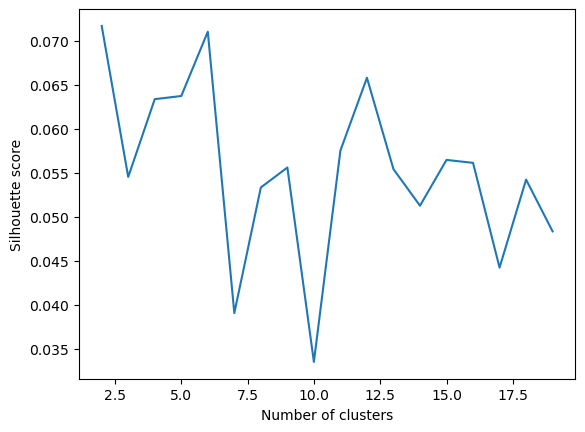

In [223]:
# construct an elbow test to find the optimal number of clusters
from sklearn.metrics import silhouette_score

def get_silhouette_score(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    return silhouette_avg

get_silhouette_score(test_embeddings, 10)

# how to interpret the silhouette score? https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# plot the silhouette score for different numbers of clusters
import matplotlib.pyplot as plt
import matplotlib.cm as cm

silhouette_scores = []
n_clusters_range = range(2, 20)
for n_clusters in n_clusters_range:
    silhouette_scores.append(get_silhouette_score(test_embeddings, n_clusters))

plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")

In [205]:
# Alternative approach: calculate distance from background embedding
# test_background_embedding = bert_sentence_embeddings([clean_text(test_row["background"])])[0]
# hack_text = "In conclusion, we found that 1-4 weeks of the intervention were necessary to prevent NEC, even after an initial 7 -14 months of treatment."
hack_text = "In conclusion, we found that there is no benefit in avoiding NEC."
# hack_text = "In conclusion, the treatment had a positive effect"
# hack_text = "In conclusion, the treatment had no significant effect"
test_background_embedding = bert_sentence_embeddings([clean_text(hack_text)])[0]  # hack

test_distances = np.linalg.norm(test_embeddings - test_background_embedding, axis=1)
print(test_distances.shape)

# print per abstract: sorted by distance. also print abstract idx and distance
# for abstract_idx, sentence, distance in zip(abstract_idx_to_sentence_idx, all_split_sentences, test_distances):
#     if abstract_idx > 5:
#         break
#     print(f"abs {abstract_idx:2d}: dist {distance:2.2f}:", sentence)

for abstract_idx in range(5):
    # only get sentences from this abstract along with their distances
    abstract_distances = test_distances[np.array(abstract_idx_to_sentence_idx) == abstract_idx]
    abstract_sentences = np.array(all_split_sentences)[np.array(abstract_idx_to_sentence_idx) == abstract_idx]

    # get top sentences' indices
    top_sentence_indices = np.argsort(abstract_distances)[:3]

    # print all sentences in order with their distances. If it's a top sentence, mark it with a *
    for sentence_idx, (sentence, distance) in enumerate(zip(abstract_sentences, abstract_distances)):
        if sentence_idx in top_sentence_indices:
            print(f"abs {abstract_idx:2d}: dist {distance:2.2f}: *", sentence)
        else:
            print(f"abs {abstract_idx:2d}: dist {distance:2.2f}:  ", sentence)

    print("---")


(263,)
abs  0: dist 8.55:   ABSTRACT A healthy intestinal microbiota is considered to be important for priming of the infants ' mucosal and systemic immunity
abs  0: dist 8.80:   Breast-fed infants typically have an intestinal microbiota dominated by different Bifidobacterium species
abs  0: dist 8.47:   It has been described that allergic infants have different levels of specific Bifidobacterium species than healthy infants
abs  0: dist 8.44:   For the accurate quantification of Bifidobacterium adolescentis , Bifidobacterium angulatum , Bifidobacterium bifidum , Bifidobacterium breve , Bifidobacterium catenulatum , Bifidobacterium dentium , Bifidobacterium infantis , and Bifidobacterium longum in fecal sample s , duplex 5′ nuclease assays were developed
abs  0: dist 8.34:   The assays , targeting rRNA gene intergenic spacer regions , were vali date d and compared with conventional PCR and fluorescent in situ hybridization methods
abs  0: dist 8.05:   The 5′ nuclease assays were subseq

In [233]:
# Simplest "model" -- follow the procedure for each abstract after sentence splitting:
# 1. Does the abstract contain the word "conclusion"? If so, get the sentence with the word "conclusion" in it and everything after it.
# 2. Otherwise, get the last two sentences.

def extract_simple(sentences: typing.List[str]) -> typing.List[typing.Tuple[int, str]]:
    """two step process. Return sentences to keep and their indices."""

    for sentence in sentences:
        if "conclusion" in sentence.lower():
            return [(s_idx, s) for s_idx, s in enumerate(sentences) if s_idx >= sentences.index(sentence)]

    return [(s_idx, s) for s_idx, s in enumerate(sentences) if s_idx >= len(sentences) - 2]

# test
# extract_simple(["This is a sentence.", "This is another sentence.", "This is a conclusion.", "This is the sentence after."])

test_extracted_sentences = []
for abstract_idx, abstract in enumerate(test_row['abstract']):
    test_extracted_sentences.append(extract_simple(split_sentences(clean_text(abstract))))

# prepare for abstractive summarization: concatenate all sentences into a single string


for abstract_idx, extracted_sentences in enumerate(test_extracted_sentences):
    print(f"abs {abstract_idx:2d}:", extracted_sentences)

abs  0: [(9, 'In conclusion , the specific prebiotic infant formula used induces a fecal microbiota that closely resembles the microbiota of breast-fed infants also at the level of the different Bifidobacterium species')]
abs  1: [(12, 'In conclusion , enteral supplementation of a prebiotic mixture does not enhance the postnatal decrease in intestinal permeability in preterm infants in the first week of life')]
abs  2: [(9, 'CONCLUSIONS GOS/lcFOS supplementation has a bifidogenic effect on maternal gut microbiota that is not transferred to neonates'), (10, 'The increased maternal bifidobacteria did not affect fetal immunity as measured by a comprehensive examination of cord blood immunity variables')]
abs  3: [(10, 'CONCLUSION This study showed the different bifidogenic properties among the substrates and underlined the importance of taking into account the baseline bifidobacteria counts when evaluating the effect of the treatment')]
abs  4: [(12, 'CONCLUSIONS Enteral supplementation o

***abstractive step***

In [253]:
import gc
import os
from transformers import AutoTokenizer, LongT5ForConditionalGeneration
from datasets import load_dataset
import pandas as pd
import torch
from torch.cuda.amp import autocast

# Memory optimization for CUDA
max_split_size_mb = 256  # Set the max_split_size_mb value (e.g., 512 MB)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = f"max_split_size_mb:{max_split_size_mb}"
print(f"PYTORCH_CUDA_ALLOC_CONF is set to: {os.environ['PYTORCH_CUDA_ALLOC_CONF']}")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("mps")
print("device:", device)

# Load LongT5 Model and Tokenizer
# model_to_use = "google/long-t5-local-base"
model_to_use = "pszemraj/long-t5-tglobal-base-16384-book-summary"  # fined-tuned for summarization
longt5_model = LongT5ForConditionalGeneration.from_pretrained(model_to_use).to(device)
longt5_tokenizer = AutoTokenizer.from_pretrained(model_to_use)

# Assuming the longt5_tokenizer and longt5_model are already correctly initialized

batch_size = 1  # this is my limit in Google Colab T4 before I start getting OOM issues
max_token_length = 16384  # truly the limit of LongT5, but can reduce by multiples of 2 to optimize for speed if needed

# Try summarizing a single review only -- from test_extracted_sentences
batch_abstracts = [". ".join([". ".join([s[1] for s in a]) for a in test_extracted_sentences])]
val_inputs = longt5_tokenizer.batch_encode_plus(
    batch_abstracts,
    return_tensors="pt",
    max_length=max_token_length,
    truncation=True,
    padding=True,
    return_attention_mask=True,
).to(device)

# Generate summaries
summary_ids = longt5_model.generate(
    val_inputs["input_ids"],
    attention_mask=val_inputs["attention_mask"],
    max_new_tokens=512,
)

# Decode summaries
batch_summaries = longt5_tokenizer.batch_decode(
    summary_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True
)

print(batch_summaries)


PYTORCH_CUDA_ALLOC_CONF is set to: max_split_size_mb:256
device: mps


/Users/michaelenghoekhor/Downloads/pytorch-test/env/lib/python3.8/site-packages/transformers/models/longt5/modeling_longt5.py:74: UserWarning: MPS: The constant padding of more than 3 dimensions is not currently supported natively. It uses View Ops default implementation to run. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Pad.mm:474.)
  x = nn.functional.pad(x, pad=pad, mode="constant", value=pad_value)
/Users/michaelenghoekhor/Downloads/pytorch-test/env/lib/python3.8/site-packages/transformers/modeling_utils.py:861: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


['In this study, we examine the effects of a specific prebiotic formula on the gut microbial community in infants. The results suggest that enteral feeding with a small amount of prebiotic fibers can be effective in reducing the risk of severe infectious morbidities in preterm babies. However, there is no significant difference in the risk between the two groups. For example, an infant fed a pre-biotic formula has a lower risk of serious infection than a standard baby formula. This suggests that it may be beneficial to use prebiotics in early pregnancy.']


In [260]:
print("background:")
pprint(test_row["background"])
print("")
print("target:")
pprint(test_row["target"])
print("")
print("generated summary:")
pprint(batch_summaries[0])

background:
('Necrotizing enterocolitis ( NEC ) is one of the most serious '
 'gastrointestinal emergencies in very low birth weight ( VLBW ) preterm '
 'neonates , affecting 7 - 14 % of these neonates .\n'
 'Due to the seriousness of the disease , prevention of NEC is the most '
 'important goal .')

target:
('Current evidence from systematic review and meta- analysis revealed that '
 'probiotics are the most promising intervention in reduction of the incidence '
 'of NEC in VLBW neonates .\n'
 'As per the evidence , prebiotics modulate the composition of human intestine '
 'microflora to the benefit of the host by suppression of colonization of '
 'harmful microorganism and /or the stimulation of bifidobacterial growth , '
 'decreased stool viscosity , reduced gastrointestinal transit time , and '
 'better feed tolerance .')

generated summary:
('In this study, we examine the effects of a specific prebiotic formula on the '
 'gut microbial community in infants. The results suggest th